In [1]:
import math
import torch
import torch.nn as nn
import einops
import torchvision
from torch import optim
import torch.nn.functional as F

# Visualization
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image
from IPython.display import HTML
import numpy as np

from torchvision import transforms
from einops.layers.torch import Rearrange

from PIL import Image


tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 

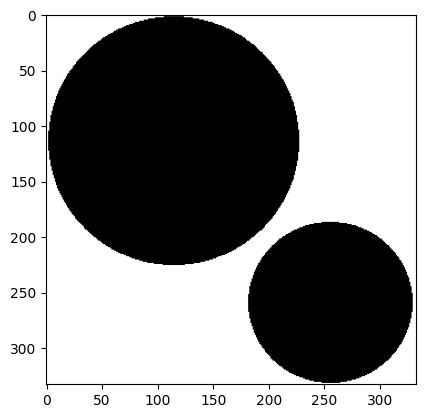

In [2]:
EDGE = False # if True the input image is set to the edge of fish silhoutte. If False use the silhoutte itself as layer's input

# PNG -> PIL.Image
image = Image.open("2circles.png")

image = torchvision.transforms.ToTensor()(image)

print(image)

if EDGE:
  class SobolevFilter(nn.Module):
      def __init__(self):
          super(SobolevFilter, self).__init__()
          # Sobolev filter kernels for edge detection
          self.sobel_x = torch.tensor([[-1, 0, 1],
                                      [-2, 0, 2],
                                      [-1, 0, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0).repeat(1, 3, 1, 1)

          self.sobel_y = torch.tensor([[-1, -2, -1],
                                      [0, 0, 0],
                                      [1, 2, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0).repeat(1, 3, 1, 1)

          # Ensure filters are treated as model parameters with no gradient updates
          self.sobel_x = nn.Parameter(self.sobel_x, requires_grad=False)
          self.sobel_y = nn.Parameter(self.sobel_y, requires_grad=False)

      def forward(self, x):
          # Apply Sobel filters to input image
          grad_x = F.conv2d(x, self.sobel_x, padding=1)
          grad_y = F.conv2d(x, self.sobel_y, padding=1)

          # Compute gradient magnitude
          grad_magnitude = torch.sqrt(grad_x ** 2 + grad_y ** 2)
          return grad_magnitude

  image = SobolevFilter()(image)

plt.imshow(image.permute(1,2,0)) # check image is correctly loaded

In [3]:
def reshape(x, n):
  return einops.rearrange(x, 'b (c n) ... -> b c n ...', n=n)

def reshape_back(x):
  return einops.rearrange(x, 'b c n ... -> b (c n) ...')

def nrm(x):
  return torch.linalg.norm(x, dim=2)

def gaussian_kernel_2d(size, sigma):
    """Function to create a 2D Gaussian kernel."""
    kernel = np.fromfunction(
        lambda x, y: np.exp(
            -((x - (size - 1) / 2) ** 2 + (y - (size - 1) / 2) ** 2) / (2 * sigma**2)
        ),
        (size, size),
    )
    return torch.Tensor(kernel)

class ModReLU(nn.Module):

    def __init__(self, n, ch, norm="gn"):
        super().__init__()
        self.n = n
        if norm == "bn":
            self.norm = nn.BatchNorm2d(ch // n)
        elif norm == "gn":
            self.norm = nn.GroupNorm(ch // n, ch // n)
        else:
            self.norm = nn.Identity()

    def forward(self, x):
        x = reshape(x, self.n)
        m = torch.linalg.norm(x, dim=2)  # [B C//n H, W]
        m = torch.nn.ReLU()(self.norm(m))  # No relu
        x = m.unsqueeze(2) * F.normalize(x, dim=2)
        x = reshape_back(x)
        return x

class KConv2d(nn.Module):

  def __init__(self, n, ch, connectivity='conv', ksize=3, init_omg=1.0, hw=(16,16), use_omega=True, use_omega_c=True):
    # connnectivity is either 'conv' or 'ca'
    super().__init__()
    assert (ch % n) == 0
    self.n = n
    self.ch = ch

    if connectivity == 'conv':
      self.connectivity = nn.Conv2d(ch, ch, ksize, 1, ksize//2, bias=False)
    elif connectivity == 'conv_mlp':
      self.connectivity = nn.Sequential(
          nn.Conv2d(ch, ch, ksize, 1, ksize//2, bias=False),
          ModReLU(n, ch),
          nn.Conv2d(ch, ch, ksize, 1, ksize//2, bias=False))
    else:
      raise NotImplementedError

    self.use_omega = use_omega
    self.use_omega_c = use_omega_c
    if use_omega or use_omega_c:
      if n == 2 :
        self.omg_param = nn.Parameter(torch.randn(ch//2, 2))
      else:
        self.omg_param = nn.Parameter(init_omg * (1/np.sqrt(n))* torch.randn(ch//n, n, n))

  def omg(self, p):
    if self.n==2:
      p = torch.linalg.norm(p, dim=1)
      return torch.stack(
          [torch.stack([torch.zeros_like(p), p], -1),
          torch.stack([-p, torch.zeros_like(p)], -1)],
              -1)
    else:
      return p - p.transpose(1, 2)

  def forward(self, x, c=None):
    y = self.connectivity(x)
    if c is not None:
      y = y + c
    y = reshape(y, self.n)
    x = reshape(x, self.n)

    omg_x = torch.einsum('cnm,bcmhw->bcnhw', self.omg(self.omg_param), x) if self.use_omega else torch.zeros_like(x)
    proj = y - torch.sum(y*x, 2, keepdim=True) * x
    if c is not None:
      c = reshape(c, self.n)
      omg_c = torch.einsum('cnm,bcmhw->bcnhw', self.omg(self.omg_param), c) if self.use_omega_c else torch.zeros_like(c)
      return reshape_back(omg_x + proj), reshape_back(omg_c)
    else:
      return reshape_back(omg_x + proj)

  def compute_energy(self, x, c=None):

    y = self.connectivity(x)
    y = y + c
    B = x.shape[0]
    return - torch.sum(x.view(B, -1) * y.view(B, -1), -1)


class KBlock(nn.Module):

  def __init__(self, n, ch, connectivity='conv', T=4, ksize=7, init_omg=0.1, c_norm='gn', use_omega=True, use_omega_c=True):
    super().__init__()
    self.n = n
    self.ch = ch
    self.T = T
    self.kconv = KConv2d(n, ch, connectivity=connectivity, ksize=ksize, init_omg=init_omg, use_omega=use_omega, use_omega_c=use_omega_c)
    self.monitor_count = 0
    if c_norm == 'gn':
      self.c_norm = nn.GroupNorm(ch//n, ch)
    else:
      self.c_norm = lambda x: x

  def normalize(self, x, y=None):
    x = reshape(x, self.n)
    x = torch.nn.functional.normalize(x, dim=2)
    if y is not None:
      x = torch.linalg.norm(reshape(y, self.n), dim=2, keepdim=True) * x
    x = reshape_back(x)
    return x

  def monitor_norms(self, dt, c, x):

    def print_norm(x, name):
      x = x.view(x.shape[0], -1).detach()
      x = torch.linalg.norm(x, dim=1).mean(0)
      print(f"avg norms of {name}: {x:.6f}")
    for x, name in ((dt, 'dt'), (c, 'c'), (x, 'x')):
      print_norm(x, name)

  def forward(self, x, c, T, gamma, del_t=1.0, return_xs=False, return_es=False, T_noc=None):
    x = self.normalize(x)
    c = self.c_norm(c)
    xs = [x]
    es = []
    if return_es:
      energy = self.kconv.compute_energy(x, c)
      es.append(energy)

    if self.monitor_count >= 50:
      do_monitoring = False
      self.monitor_count = 0
    else:
      do_monitoring = False
      self.monitor_count += 1

    for t in range(T):
      dxdt, dcdt = self.kconv(x, c)
      _c = c + gamma*del_t*dcdt
      c = self.normalize(_c, c)
      x = x + gamma*del_t*dxdt
      x = self.normalize(x)

      if return_es:
        energy = self.kconv.compute_energy(x, c)
        es.append(energy)

      if return_xs:
        xs.append(x)

    if return_es:
      return x, xs, es
    else:
      return x, xs


class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)

In [19]:
import random
import numpy as np
ch = 4
n = 4
c_strength = 1.
h, w = 92, 92

# Set random seed. You can see different wave patterns by changing this seed number
seed = 20
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

# initialize K-Layer. The random seed determines the value of omega, which is the natural frequency term of oscillators.
kblock = KBlock(n, ch, 'conv', 256, ksize=13, init_omg=0.1, c_norm=None, use_omega_c=False)

image = torchvision.transforms.functional.to_pil_image(image)
image = torchvision.transforms.Resize((64, 64))(image)
image = torchvision.transforms.ToTensor()(image)
image = image[:1].repeat(4, 1, 1)

# compute c
c = nn.AdaptiveAvgPool2d((h,w))(image[None])
c = c_strength * c

In [20]:
x = torch.randn(1, ch, h, w)
T = 256
x, xs, es = kblock(x, c, T=T, gamma=0.5, return_xs=True, del_t=1.2, return_es=True)

In [ ]:
B = 1
xsarr = torch.stack(xs, 2)
print(xsarr.shape)
nframes = xsarr.shape[2]
H,W = xsarr.shape[3:]
xsarr = xsarr.reshape(xsarr.shape[0], xsarr.shape[1], -1).transpose(-2, -1)
xsarr = xsarr.detach().cpu().numpy()
print(xsarr.shape)

nxarrs = []
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
for b in range(B):
  nxarrs.append(PCA(3).fit_transform(xsarr[b]).reshape(nframes, H, W, 3))

images = []
for i in range(nframes):
  nxs = []

  for b in range(B):
    nxs.append(np.clip(nxarrs[b][i], -1, 1))
  nx = np.concatenate(nxs, 1)
  nx = (nx + 1)/2

  images.append(nx)

plt.figure()

fig, ax = plt.subplots()
print(images[0].shape)
img_plot = ax.imshow(images[0])
ax.axis('off')
def update(frame):
    img_plot.set_array(images[frame])
    return img_plot,

# make animation
ani = animation.FuncAnimation(fig, update, frames=len(images), interval=30, blit=True)
# display animation as HTML
HTML(ani.to_jshtml())

torch.Size([1, 4, 257, 92, 92])
(1, 2175248, 4)
(92, 92, 3)
